## 템플릿 매칭 기반 약품 분류 코드

### 라이브러리 임포트

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile
from tqdm import tqdm # 진행 상황을 시각적으로 보여주기 위한 라이브러리
import matplotlib.pyplot as plt

print("✅ 라이브러리 임포트 완료!")

✅ 라이브러리 임포트 완료!


### 데이터셋 준비

In [2]:
# Kaggle API 설정
kaggle_api = KaggleApi()
kaggle_api.authenticate()

# 데이터셋 다운로드 경로 및 파일 이름 설정
dataset_name = 'gauravduttakiit/pharmaceutical-drug-recognition'
download_path = '.'
zip_file_name = 'pharmaceutical-drug-recognition.zip'

# 데이터셋이 이미 준비되지 않았다면 다운로드 및 압축 해제
if not os.path.exists('train'):
    print("데이터셋 다운로드를 시작합니다...")
    kaggle_api.dataset_download_files(dataset_name, path=download_path, quiet=False)
    
    print(f"'{zip_file_name}' 파일 압축 해제를 시작합니다...")
    with ZipFile(zip_file_name, 'r') as zip_ref:
        zip_ref.extractall(download_path)
    
    os.remove(zip_file_name)
    print("✅ 데이터셋 준비 완료!")
else:
    print("✅ 데이터셋이 이미 준비되었습니다.")

✅ 데이터셋이 이미 준비되었습니다.


### 각 약품의 대표 템플릿 생성(학습 단계)

In [6]:
from sklearn.model_selection import train_test_split

# 상수 및 경로 설정
DATA_DIR = 'train' # 실제 이미지는 train 폴더에 모두 있습니다.
CSV_FILE = 'Training_set.csv'
IMG_SIZE = (128, 128)

# 정답이 포함된 전체 CSV 파일 로드
df_full = pd.read_csv(CSV_FILE)

# 전체 데이터를 템플릿 생성용(80%)과 평가용(20%)으로 분할합니다.
# stratify=df_full['label'] 옵션은 각 약품의 비율을 유지하며 나눠주므로 매우 중요합니다.
df_template_creation, df_evaluation = train_test_split(
    df_full,
    test_size=0.2,
    random_state=42,
    stratify=df_full['label']
)

print(f"템플릿 생성용 데이터: {len(df_template_creation)}개")
print(f"평가용 데이터: {len(df_evaluation)}개")

# --- 템플릿 생성 (df_template_creation 사용) ---
drug_classes = df_full['label'].unique() # 전체 클래스 목록은 유지
templates = {}

print(f"\n총 {len(drug_classes)}개의 약품 클래스에 대한 템플릿을 생성합니다.")

for drug in drug_classes:
    # 각 약품의 첫 번째 이미지를 템플릿으로 선택
    template_row = df_template_creation[df_template_creation['label'] == drug].iloc[0]
    # 이미지는 'train' 폴더 안에 있으므로 DATA_DIR 경로를 사용합니다.
    template_path = os.path.join(DATA_DIR, template_row['filename'])
    
    # 이미지를 흑백으로 읽고 리사이즈
    template_image = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    template_image = cv2.resize(template_image, IMG_SIZE)
    
    templates[drug] = template_image

print("✅ 모든 클래스에 대한 템플릿 생성을 완료했습니다.")

템플릿 생성용 데이터: 5600개
평가용 데이터: 1400개

총 10개의 약품 클래스에 대한 템플릿을 생성합니다.
✅ 모든 클래스에 대한 템플릿 생성을 완료했습니다.


### 테스트 이미지로 예측 및 정확도 측정(평가)

In [7]:
correct_predictions = 0
# 이제 df_evaluation 데이터프레임으로 평가합니다.
total_predictions = len(df_evaluation)

print("\n분할된 평가용 데이터로 평가를 시작합니다...")

# tqdm을 사용하여 진행률 표시
for index, row in tqdm(df_evaluation.iterrows(), total=total_predictions):
    # 이미지는 여전히 'train' 폴더 안에 있습니다.
    test_image_path = os.path.join(DATA_DIR, row['filename'])
    
    # df_evaluation에는 'label' 열이 존재하므로 오류가 발생하지 않습니다.
    true_label = row['label']
    
    # 테스트 이미지를 흑백으로 읽고 리사이즈
    test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
    if test_image is None:
        continue # 이미지를 불러오지 못한 경우 건너뛰기
    test_image = cv2.resize(test_image, IMG_SIZE)
    
    best_match_score = -1
    predicted_label = None
    
    # 모든 템플릿과 비교
    for drug_name, template in templates.items():
        result = cv2.matchTemplate(test_image, template, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(result)
        
        if max_val > best_match_score:
            best_match_score = max_val
            predicted_label = drug_name
            
    # 예측과 정답 비교
    if predicted_label == true_label:
        correct_predictions += 1

# 최종 정확도 계산
accuracy = (correct_predictions / total_predictions) * 100

print("\n✅ 평가 완료!")
print(f"정확하게 예측한 이미지 수: {correct_predictions} / {total_predictions}")
print(f"최종 정확도 (Accuracy): {accuracy:.2f}%")


분할된 평가용 데이터로 평가를 시작합니다...


100%|█████████████████████████████████████████████████████████████████████████████| 1400/1400 [00:02<00:00, 592.37it/s]


✅ 평가 완료!
정확하게 예측한 이미지 수: 141 / 1400
최종 정확도 (Accuracy): 10.07%


C:\Users\dudgh\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dudgh\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45813 (\N{HANGUL SYLLABLE DAB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dudgh\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dudgh\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


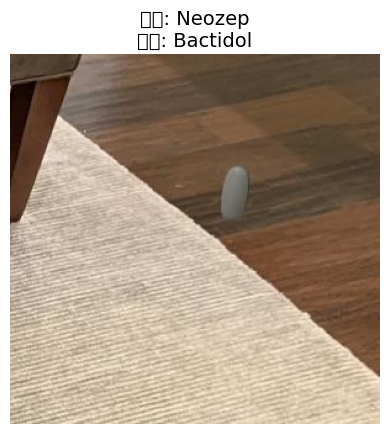

✅ 정답 약 이름: Neozep
✅ 모델의 예측: Bactidol (유사도: 0.40)

예측이 틀렸습니다. 😥


In [9]:
# 평가용 데이터프레임(df_evaluation)에서 테스트할 이미지 선택
# 0부터 len(df_evaluation) - 1 사이의 숫자로 바꿔보세요.
image_index = 15 

# 선택한 이미지의 정보 가져오기
sample_row = df_evaluation.iloc[image_index]
image_path = os.path.join(DATA_DIR, sample_row['filename'])
true_label = sample_row['label']

# --- 예측 과정 수행 ---
# 시각화를 위해 컬러 이미지도 불러오기
color_image = cv2.imread(image_path)

# 예측을 위해서는 흑백 이미지 사용 (오타 수정: COLOR_BGR2GRAYSCALE -> COLOR_BGR2GRAY)
gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
gray_image = cv2.resize(gray_image, IMG_SIZE)

best_match_score = -1
predicted_label = None

for drug_name, template in templates.items():
    result = cv2.matchTemplate(gray_image, template, cv2.TM_CCOEFF_NORMED)
    _, max_val, _, _ = cv2.minMaxLoc(result)
    
    if max_val > best_match_score:
        best_match_score = max_val
        predicted_label = drug_name

# --- 결과 시각화 ---
# OpenCV는 BGR, Matplotlib은 RGB 순서로 색상을 처리하므로 변환 필요
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
plt.title(f"정답: {true_label}\n예측: {predicted_label}", fontsize=14)
plt.axis('off')
plt.show()

print(f"✅ 정답 약 이름: {true_label}")
print(f"✅ 모델의 예측: {predicted_label} (유사도: {best_match_score:.2f})")

if true_label == predicted_label:
    print("\n정확하게 예측했습니다! 🎉")
else:
    print("\n예측이 틀렸습니다. 😥")